In [42]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import datetime, os
import collections
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import sequence
import simplejson as json
import tensorflow as tf
import pandas as pd
import os
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from sklearn import metrics as skmetrics
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from keras.utils.vis_utils import plot_model
from keras import metrics
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input, Dropout, Embedding, concatenate, SimpleRNN, Conv1D, MaxPooling1D
from keras.utils.vis_utils import plot_model
from google.cloud import storage
from google.cloud.storage import Blob

client = storage.Client(project="ds5500")

bucket = client.get_bucket("kkbox-data")

#INPUT_PATH = "D:\\Northeastern\\100 pct undersample split\\"
INPUT_PATH = "gs://kkbox-data/50_pct_undersample/"

In [23]:
# Create F1 score as an evaluation metric
# https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

import sklearn.metrics as skmetrics


# Load Member/Transaction Data

In [24]:
# Load TRAINING data
temp_path = "/tmp/train_transactions_monthly_padded.npy"
blob = Blob("50_pct_undersample/train_transactions_monthly_padded.npy", bucket)
with open(temp_path, "wb") as file_obj:
    blob.download_to_file(file_obj)
X_transactions = np.load(temp_path)
X_members = pd.read_csv(INPUT_PATH + "train_members_transformed.csv").sort_values("msno").drop(["msno","is_churn"],axis=1).values
y = pd.read_csv(INPUT_PATH + "train_members_transformed.csv").sort_values("msno").is_churn.values

In [25]:
# Load VALIDATION data
temp_path = "/tmp/val_transactions_monthly_padded.npy"
blob = Blob("50_pct_undersample/val_transactions_monthly_padded.npy", bucket)
with open(temp_path, "wb") as file_obj:
    blob.download_to_file(file_obj)
X_val_transactions = np.load(temp_path)
X_val_members = pd.read_csv(INPUT_PATH + "val_members_transformed.csv").sort_values("msno").drop(["msno","is_churn"],axis=1).values
y_val = pd.read_csv(INPUT_PATH + "val_members_transformed.csv").sort_values("msno").is_churn

## Load Weekly User Logs

In [26]:
# Load training weekly user logs from GCS
temp_path = "/tmp/train_user_logs_weekly_padded.npy"
blob = Blob("50_pct_undersample/train_user_logs_weekly_padded.npy", bucket)

with open(temp_path, "wb") as file_obj:
    blob.download_to_file(file_obj)
X_user_logs = np.load(temp_path)

In [27]:
# Load testing weekly user logs from GCS
temp_path = "/tmp/val_user_logs_weekly_padded.npy"
blob = Blob("50_pct_undersample/val_user_logs_weekly_padded.npy", bucket)

with open(temp_path, "wb") as file_obj:
    blob.download_to_file(file_obj)
X_val_user_logs = np.load(temp_path)

# Just Weekly User Logs

In [ ]:
batch_size = 64
epochs = 50
lstm_units = 16

num_dates = X_user_logs.shape[1]
num_user_log_cols = X_user_logs.shape[2]

data_in_a = Input(shape = (num_dates,num_user_log_cols))
a = LSTM(lstm_units, return_sequences=True)(data_in_a)
a = Conv1D(filters=16, kernel_size=5, strides=2)(a)
a = MaxPooling1D()(a)
a = LSTM(lstm_units)(a)
a = Dense(8)(a)
a = Dropout(.2)(a)
a = Dense(8)(a)
out = Dense(1, activation='sigmoid')(a)

model = Model(inputs=data_in_a, outputs=out)
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = [f1])

model.summary()
history_1 = model.fit(X_user_logs, y, batch_size=batch_size, validation_data=(X_val_user_logs,y_val), epochs=epochs,verbose=1,use_multiprocessing=True)

Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        (None, 215, 7)            0         
_________________________________________________________________
lstm_44 (LSTM)               (None, 215, 16)           1536      
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 106, 16)           1296      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 53, 16)            0         
_________________________________________________________________
lstm_45 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_57 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0  

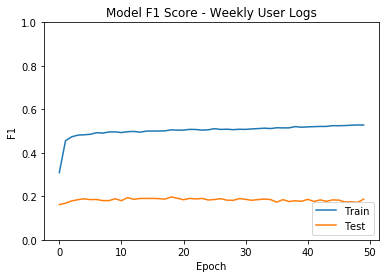

In [47]:
# Plot training & validation accuracy values
plt.plot(history_1.history['f1'])
plt.plot(history_1.history['val_f1'])
plt.title('Model F1 Score - Weekly User Logs')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.ylim([0,1])
plt.show()

# Weekly User Logs, Member Data, Transaction Data

In [51]:
batch_size = 64
epochs = 50
lstm_units = 16
rnn_units = 16

num_members = X_user_logs.shape[0]
num_dates = X_user_logs.shape[1]
num_user_log_cols = X_user_logs.shape[2]
num_member_cols = X_members.shape[1]
num_transaction_cols = X_transactions.shape[2]
num_transaction_months = X_transactions.shape[1]

data_in_a = Input(shape = (num_dates,num_user_log_cols))
a = LSTM(lstm_units, return_sequences=True)(data_in_a)
a = Conv1D(filters=16, kernel_size=5, strides=2)(a)
a = MaxPooling1D()(a)
a = LSTM(lstm_units)(a)
a = Dense(16, activation='relu')(a)
a_mod = Model(data_in_a, outputs=a)

data_in_b = Input(shape = (num_member_cols,))
b = Dense(16, activation='relu')(data_in_b)
b_mod = Model(data_in_b, outputs=b)

data_in_c = Input(shape = (num_transaction_months,num_transaction_cols,))
c = SimpleRNN(rnn_units)(data_in_c)
c = Dense(16, activation='relu')(c)
c_mod = Model(data_in_c, outputs=c)

combined = concatenate([a_mod.output, b_mod.output, c_mod.output])
out = Dense(32, activation='relu')(combined)
out = Dense(16, activation='relu')(out)
out = Dense(1, activation='sigmoid')(out)

model = Model(inputs=[a_mod.input, b_mod.input, c_mod.input], outputs=out)
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = [f1])

model.summary()
history_2 = model.fit([X_user_logs, X_members, X_transactions], y, validation_data=([X_val_user_logs, X_val_members, X_val_transactions],y_val), batch_size=batch_size, epochs=epochs,verbose=1,use_multiprocessing=True)


Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, 31, 7)        0                                            
__________________________________________________________________________________________________
lstm_36 (LSTM)                  (None, 31, 16)       1536        input_28[0][0]                   
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 14, 16)       1296        lstm_36[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 7, 16)        0           conv1d_14[0][0]                  
___________________________________________________________________________________________

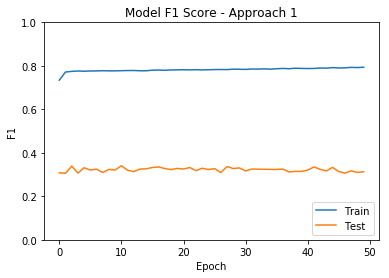

In [53]:
# Plot training & validation accuracy values
plt.plot(history_2.history['f1'])
plt.plot(history_2.history['val_f1'])
plt.title('Model F1 Score - Approach 1')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.ylim([0,1])
plt.show()

# Load Daily User Logs

In [54]:
# Load user logs from GCS
temp_path = "/tmp/train_user_logs_padded.npy"
blob = Blob("50_pct_undersample/train_user_logs_padded.npy", bucket)

with open(temp_path, "wb") as file_obj:
    blob.download_to_file(file_obj)
X_user_logs = np.load(temp_path)

In [55]:
# Load user logs from GCS
temp_path = "/tmp/val_user_logs_padded.npy"
blob = Blob("50_pct_undersample/val_user_logs_padded.npy", bucket)

with open(temp_path, "wb") as file_obj:
    blob.download_to_file(file_obj)
X_val_user_logs = np.load(temp_path)

# Just Daily User Logs

In [58]:
batch_size = 128
epochs = 50
lstm_units = 16

num_dates = X_user_logs.shape[1]
num_user_log_cols = X_user_logs.shape[2]

data_in_a = Input(shape = (num_dates,num_user_log_cols))
a = LSTM(lstm_units, return_sequences=True)(data_in_a)
a = Conv1D(filters=16, kernel_size=5, strides=2)(a)
a = MaxPooling1D()(a)
a = LSTM(lstm_units)(a)
a = Dense(8)(a)
a = Dense(8)(a)
out = Dense(1, activation='sigmoid')(a)

model = Model(inputs=data_in_a, outputs=out)
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = [f1])

#model.summary()
history_3 = model.fit(X_user_logs, y, batch_size=batch_size, validation_data=(X_val_user_logs,y_val), epochs=epochs,verbose=1,use_multiprocessing=True)


Train on 53483 samples, validate on 21517 samples
Epoch 1/50
53483/53483 [==============================] - 70s 1ms/step - loss: 0.5979 - f1: 0.2042 - val_loss: 0.4021 - val_f1: 0.1782
Epoch 2/50
53483/53483 [==============================] - 69s 1ms/step - loss: 0.5573 - f1: 0.4733 - val_loss: 0.3983 - val_f1: 0.1798
Epoch 3/50
53483/53483 [==============================] - 66s 1ms/step - loss: 0.5526 - f1: 0.4927 - val_loss: 0.3876 - val_f1: 0.1857
Epoch 4/50
53483/53483 [==============================] - 67s 1ms/step - loss: 0.5497 - f1: 0.4995 - val_loss: 0.3752 - val_f1: 0.1946
Epoch 5/50
53483/53483 [==============================] - 66s 1ms/step - loss: 0.5481 - f1: 0.5025 - val_loss: 0.3690 - val_f1: 0.1917
Epoch 6/50
53483/53483 [==============================] - 66s 1ms/step - loss: 0.5470 - f1: 0.5041 - val_loss: 0.3636 - val_f1: 0.1905
Epoch 7/50
53483/53483 [==============================] - 67s 1ms/step - loss: 0.5453 - f1: 0.5068 - val_loss: 0.3496 - val_f1: 0.2030
Epoch

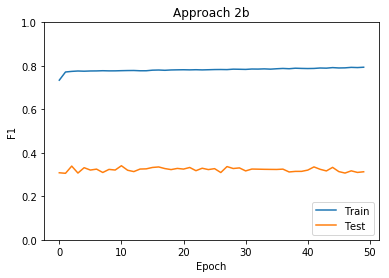

In [60]:
# Plot training & validation accuracy values
plt.plot(history_2.history['f1'])
plt.plot(history_2.history['val_f1'])
plt.title('Approach 2b')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.ylim([0,1])
plt.show()

# User Logs, Transactions, Member Data

In [32]:
batch_size = 64
epochs = 20
lstm_units = 16
rnn_units = 16

num_members = X_user_logs.shape[0]
num_dates = X_user_logs.shape[1]
num_user_log_cols = X_user_logs.shape[2]
num_member_cols = X_members.shape[1]
num_transaction_cols = X_transactions.shape[2]
num_transaction_months = X_transactions.shape[1]

data_in_a = Input(shape = (num_dates,num_user_log_cols))
a = LSTM(lstm_units)(data_in_a)
#a = LSTM(lstm_units)(a)
a = Dense(16, activation='relu')(a)
a_mod = Model(data_in_a, outputs=a)

data_in_b = Input(shape = (num_member_cols,))
b = Dense(16, activation='relu')(data_in_b)
b_mod = Model(data_in_b, outputs=b)

data_in_c = Input(shape = (num_transaction_months,num_transaction_cols,))
c = SimpleRNN(rnn_units)(data_in_c)
c_mod = Model(data_in_c, outputs=c)

combined = concatenate([a_mod.output, b_mod.output, c_mod.output])
out = Dense(16, activation='relu')(combined)
#TODO add dropout layer
out = Dense(1, activation='sigmoid')(out)

model = Model(inputs=[a_mod.input, b_mod.input, c_mod.input], outputs=out)
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = [tf.metrics.AUC()])

#model.summary()
model.fit([X_user_logs, X_members, X_transactions], y, batch_size=batch_size, epochs=epochs,verbose=1,use_multiprocessing=True)


Epoch 1/20
24798/24798 [==============================] - 82s 3ms/step - loss: 0.4716 - auc_7: 0.8200
Epoch 2/20
24798/24798 [==============================] - 72s 3ms/step - loss: 0.4145 - auc_7: 0.8664
Epoch 3/20
24798/24798 [==============================] - 78s 3ms/step - loss: 0.4077 - auc_7: 0.8756
Epoch 4/20
24798/24798 [==============================] - 78s 3ms/step - loss: 0.4037 - auc_7: 0.8802
Epoch 5/20
24798/24798 [==============================] - 81s 3ms/step - loss: 0.4006 - auc_7: 0.8833
Epoch 6/20
24798/24798 [==============================] - 78s 3ms/step - loss: 0.3983 - auc_7: 0.8856
Epoch 7/20
24798/24798 [==============================] - 80s 3ms/step - loss: 0.3966 - auc_7: 0.8873
Epoch 8/20
24798/24798 [==============================] - 78s 3ms/step - loss: 0.3961 - auc_7: 0.8887
Epoch 9/20
24798/24798 [==============================] - 80s 3ms/step - loss: 0.3954 - auc_7: 0.8897
Epoch 10/20
24798/24798 [==============================] - 78s 3ms/step - loss: 0.

# Transactions and Member Data

In [33]:
batch_size = 64
epochs = 20
lstm_units = 16
rnn_units = 16

num_members = X_user_logs.shape[0]
num_dates = X_user_logs.shape[1]
num_user_log_cols = X_user_logs.shape[2]
num_member_cols = X_members.shape[1]
num_transaction_cols = X_transactions.shape[2]
num_transaction_months = X_transactions.shape[1]

data_in_b = Input(shape = (num_member_cols,))
b = Dense(16, activation='relu')(data_in_b)
b_mod = Model(data_in_b, outputs=b)

data_in_c = Input(shape = (num_transaction_months,num_transaction_cols,))
c = SimpleRNN(rnn_units)(data_in_c)
c_mod = Model(data_in_c, outputs=c)

combined = concatenate([b_mod.output, c_mod.output])
out = Dense(16, activation='relu')(combined)
#TODO add dropout layer
out = Dense(1, activation='sigmoid')(out)

model = Model(inputs=[b_mod.input, c_mod.input], outputs=out)
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = [tf.metrics.AUC()])

#model.summary()
model.fit([X_members, X_transactions], y, batch_size=batch_size, epochs=epochs,verbose=1,use_multiprocessing=True)


Epoch 1/20
24798/24798 [==============================] - 3s 104us/step - loss: 0.4765 - auc_8: 0.8282
Epoch 2/20
24798/24798 [==============================] - 2s 78us/step - loss: 0.4266 - auc_8: 0.8589
Epoch 3/20
24798/24798 [==============================] - 2s 81us/step - loss: 0.4209 - auc_8: 0.8659
Epoch 4/20
24798/24798 [==============================] - 2s 83us/step - loss: 0.4173 - auc_8: 0.8700
Epoch 5/20
24798/24798 [==============================] - 2s 81us/step - loss: 0.4152 - auc_8: 0.8729
Epoch 6/20
24798/24798 [==============================] - 2s 80us/step - loss: 0.4143 - auc_8: 0.8750
Epoch 7/20
24798/24798 [==============================] - 2s 80us/step - loss: 0.4128 - auc_8: 0.8766
Epoch 8/20
24798/24798 [==============================] - 2s 80us/step - loss: 0.4112 - auc_8: 0.8778
Epoch 9/20
24798/24798 [==============================] - 2s 79us/step - loss: 0.4094 - auc_8: 0.8788
Epoch 10/20
24798/24798 [==============================] - 2s 82us/step - loss: 0

# User Logs and Member Data (LSTM)

# Member data only

# Visualize Model

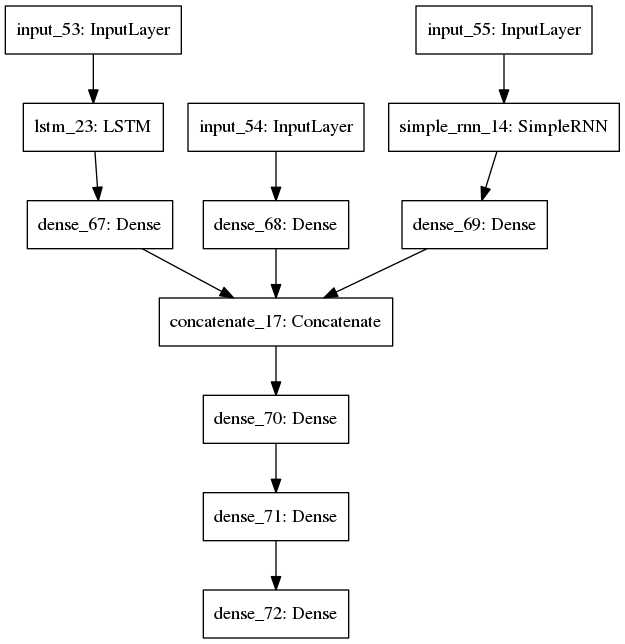

In [59]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

from keras.utils import plot_model
plot_model(model, to_file='model.png')